In [1]:
# Thư viện xử lý dữ liệu
import pandas as pd
import numpy as np
from collections import Counter

# Thư viện xử lý văn bản
import re
from nltk.tokenize import word_tokenize
from pyvi import ViTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Thư viện học máy
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder

# Thư viện vẽ biểu đồ
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Thư viện TensorFlow/Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

# EDA và TIỀN XỬ LÝ

In [2]:
# Đọc dữ liệu và kiểm tra thuộc tính
eda_data = pd.read_csv('Reviews.csv')

# In dữ liệu ban đầu
eda_data

,id,language,rating,additionalRatings,createdDate,helpfulVotes,username,userId,title,text,locationId,parentGeoId,hotelName,stayDate,tripType
0,654797953,vi,4,[],2019-02-25,1,Lephuchau,F31010A9913D4D5EF71C19943112119E,Một đêm khó ngủ,- Nằm ở số 4 Tôn Đức Thắng (trong khu villa ca...,14775963,651661,Hana Riverside Villa,2019-02-28,COUPLES
1,759960236,en,4,"[{'rating': 5, 'ratingLabel': 'Sự sạch sẽ'}, {...",2020-07-14,0,Lê T,5EEE52E4A46EB17EDB101F2687176104,Nice choice for short stay (hope the contructi...,"Hana Riverside Quang Ngai hotel, - Located in ...",14775963,651661,Hana Riverside Villa,2020-02-29,NONE
2,746020346,en,5,[],2020-02-18,0,Pipes79,9266F1E4EB6B7888598CAFA3CA535D94,Lovely stay,Dropped in here for 1 night on my way north. F...,14775963,651661,Hana Riverside Villa,2020-02-29,SOLO
3,710719324,en,4,[],2019-09-17,0,Chels2210,2930D0F21694986E614640B46EAC7FF6,Good room,Stayed here for one night while passing throug...,14775963,651661,Hana Riverside Villa,2019-09-30,COUPLES
4,658526310,vi,4,[],2019-03-14,0,Andy M,A1C68DD5908359E499974361DADF0117,Một công việc đang tiến triển - theo nghĩa đen.,"Khách sạn đẹp, nhân viên và các cơ sở nhưng cô...",14775963,651661,Hana Riverside Villa,2019-03-31,SOLO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62882,529028174,vi,5,[],2017-10-02,1,peter150881,8D07ECA38DDBA8817E93E9E0DBCEFB8E,Khách sạn tốt,Sau chuyến đi Sapa. . chúng tôi đã đi đến bình...,12799683,789432,Putaleng Hotel,2017-10-31,COUPLES
62883,527273004,nl,3,[],2017-09-25,1,RaffBnnr,FA156248E1720577890842CFBA6E8A97,Nieuw in de toerismebranche,Putalenghotel is een leuk hotel met vriendelij...,12799683,789432,Putaleng Hotel,2017-09-30,COUPLES
62884,522207067,nl,5,[],2017-09-07,2,Christof I,5F520F0F4F84788565EA76279637BAC0,Je voelt je deel van de familie,Gezellig hotel waar de hele familie in werkt. ...,12799683,789432,Putaleng Hotel,2017-09-30,COUPLES
62885,788473940,vi,5,[],2021-05-10,0,Jeremy L,63A02B46B7737043852CF3BE486B757F,Rất tuyệt vời cho chuyến công tác tại Đức Hòa ...,Tôi có chuyến công tác tại khu công nghiệp Hải...,23303565,23369392,Khách Sạn Phú Thắng,2021-04-30,BUSINESS


In [36]:
# Hiển thị thông tin cơ bản về dữ liệu
properties_check = pd.DataFrame({
    'Số quan sát': eda_data.count(),
    'Số giá trị unique': eda_data.nunique(),
    'Kiểu dữ liệu': eda_data.dtypes.values
})
properties_check

,Số quan sát,Số giá trị unique,Kiểu dữ liệu
sentiment,3003,3,object
review,3003,3003,object


In [4]:
### Lấy dữ liệu tiếng việt và gán nhãn sentiment
# Lọc dữ liệu tiếng Việt và chọn các cột cần thiết
eda_data = eda_data[eda_data['language'] == 'vi'][['rating', 'title', 'text']].drop_duplicates().dropna()

# Gắn nhãn sentiment
eda_data['sentiment'] = eda_data['rating'].apply(lambda x: 'negative' if x < 3 else 'positive' if x > 3 else 'neutral')

# In dữ liệu sau có nhãn
eda_data

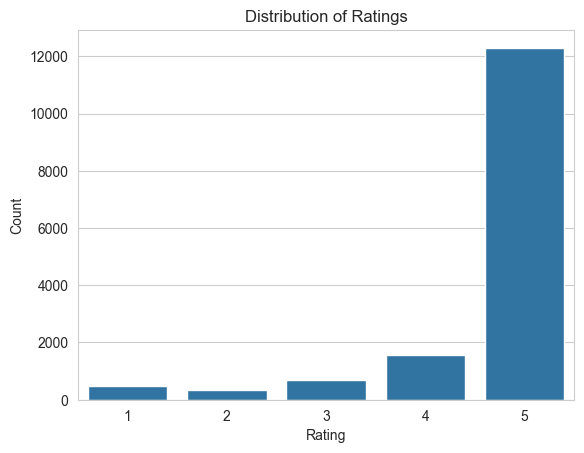

In [7]:
# Biểu đồ phân phối rating
sns.countplot(x='rating', data=eda_data)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

In [8]:
def plot_sentiment_distribution(data_plot):
    """
    Vẽ biểu đồ phân phối tỷ lệ phần trăm của các nhãn cảm xúc trong dữ liệu.

    Args:
        data_plot (DataFrame): Dữ liệu đầu vào chứa cột 'sentiment', với các nhãn cảm xúc (ví dụ: positive, negative, neutral).
    """
    plt.figure(figsize=(8, 6))
    label_percentage = data_plot['sentiment'].value_counts(normalize=True) * 100
    label_percentage.plot(kind='bar', color='skyblue')
    plt.title('Percentage Distribution of Sentiment Labels')
    plt.xlabel('Sentiment')
    plt.ylabel('Percentage (%)')
    plt.grid(axis='x')
    plt.xticks(rotation=0)
    
    # Thêm tỷ lệ phần trăm vào mỗi thanh của biểu đồ
    for i, v in enumerate(label_percentage):
        plt.text(i, v + 1, f'{v:.2f}%', ha='center', va='bottom')
    
    plt.show()

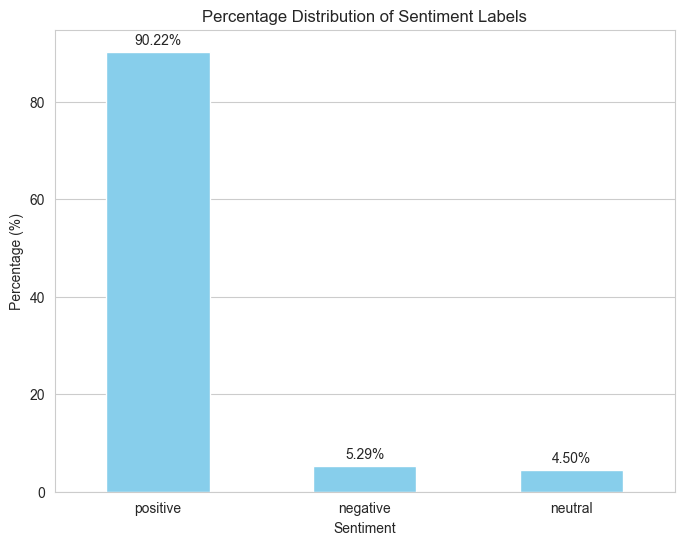

In [9]:
# Vẽ biểu đồ phân phối các nhãn ban đầu
plot_sentiment_distribution(eda_data)

In [10]:
### Giảm kích thước số lượng nhãn 'positive'
# Lọc dữ liệu có nhãn 'positive' (lấy 1500 dòng)
positive_data = eda_data[eda_data['sentiment'] == 'positive'].head(1500)

# Lọc dữ liệu có nhãn 'negative' và 'neutral' (lấy tất cả)
negative_neutral_data = eda_data[eda_data['sentiment'].isin(['negative', 'neutral'])]

# Kết hợp dữ liệu lại (1500 dòng positive và tất cả dòng negative/neutral)
eda_data = pd.concat([positive_data, negative_neutral_data])

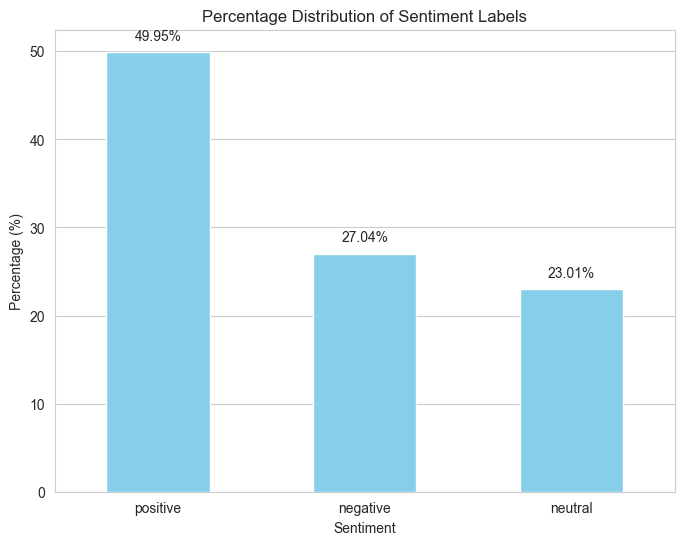

In [11]:
# Vẽ biểu đồ phân phối các nhãn sau khi lọc
plot_sentiment_distribution(eda_data)

# TEXT MINING

Các hàm cần thiết

In [12]:
def clean_text(text):
    """
    Làm sạch văn bản bằng cách loại bỏ dấu câu, chuẩn hóa khoảng trắng và chuyển đổi thành chữ thường.

    Args:
        text (str): Chuỗi văn bản cần làm sạch.

    Returns:
        str: Văn bản đã được làm sạch, không có dấu câu, chuẩn hóa khoảng trắng và chữ thường.
    """
    text = re.sub(r'[^\w\s]', '', text)  # Loại bỏ dấu câu
    text = re.sub(r'\s+', ' ', text).strip().lower()  # Chuẩn hóa khoảng trắng và chữ thường
    
    return text

In [ ]:
def filter_words(text, word_list_file='TuDon.txt'):
    """
    Lọc các từ trong văn bản, chỉ giữ lại những từ có trong danh sách cho phép.

    Args:
        text (str): Chuỗi văn bản cần lọc.
        word_list_file (str, optional): Đường dẫn tới tệp chứa danh sách các từ cho phép. Mặc định là 'TuDon.txt'.

    Returns:
        str: Văn bản sau khi lọc, chỉ chứa các từ có trong danh sách cho phép.
    """
    with open(word_list_file, 'r', encoding='utf-8') as f:
        word_list = set(f.read().splitlines())
        
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word in word_list]
    
    return ' '.join(filtered_tokens)

In [ ]:
def process_text(text, stopword_file='vietnamese-stopwords.txt'):
    """
    Tokenize văn bản và loại bỏ các từ dừng (stopwords) từ văn bản.

    Args:
        text (str): Chuỗi văn bản cần xử lý.
        stopword_file (str, optional): Đường dẫn tới tệp chứa danh sách các từ dừng. Mặc định là 'vietnamese-stopwords.txt'.

    Returns:
        str: Văn bản sau khi đã tokenized và loại bỏ các từ dừng.
    """
    with open(stopword_file, 'r', encoding='utf-8') as f:
        stopwords = set(f.read().splitlines())
    tokenized = ViTokenizer.tokenize(text)
    filtered = [word for word in tokenized.split() if word not in stopwords]
    
    return ' '.join(filtered)

Kết hơp cột 'title' và 'text' và sau đó xử lý văn bản

In [13]:
# Kết hợp cột 'title' và 'text' thành một chuỗi duy nhất, sau đó làm sạch văn bản bằng cách sử dụng hàm clean_text
eda_data['review'] = (eda_data['title'] + ' ' + eda_data['text']).apply(clean_text)

# Áp dụng hàm filter_words để lọc các từ trong cột 'review' chỉ giữ lại các từ có trong danh sách cho phép
eda_data['filtered_review'] = eda_data['review'].apply(filter_words)

# Áp dụng hàm process_text để token hóa và loại bỏ các stopwords từ cột 'filtered_review'
eda_data['processed_review'] = eda_data['filtered_review'].apply(process_text)

In [15]:
# Tổng hợp dữ liệu sau xử lý
eda_data = eda_data[['sentiment', 'processed_review']].rename(columns={'processed_review': 'review'})

In [16]:
# In dữ liệu cuối cùng sau khi xử lý
eda_data

,sentiment,review
0,positive,đêm ngủ nằm tôn đức thắng khu cao_cấp đối_diện...
4,positive,công_việc tiến_triển nghĩa_đen khách_sạn đẹp n...
8,positive,tuyệt_vời nghỉ_dưỡng quảng_ngãi dịp công_tác q...
9,positive,nghỉ_dưỡng tuyệt_vời khai_trương vắng_vẻ yên_t...
10,positive,địa_điểm lý_tưởng quảng_ngãi vô_tình ghé khách...
...,...,...
61927,neutral,ồn_ào gia_đình phòng thời_gian chúng_tôi tổ_ch...
62502,neutral,chỗ ok chỗ sạch_sẽ hòa không_khí tuy_nhiên chỗ...
62516,negative,kiểm_tra đi chúng_tôi du_lịch đồng_bằng sông c...
62611,negative,tiền vì_vậy giới_thiệu kiểm_tra đối_tác sống h...


# TRỰC QUAN HÓA

In [17]:
visual_data = eda_data.copy()

Các hàm cần thiết

In [18]:
def get_top_words(df, sentiment, top_n=10):
    """
    Tách các từ trong cột review và đếm số lần xuất hiện của từng từ, lọc theo sentiment và lấy top N từ xuất hiện nhiều nhất.

    Args:
        df (pandas DataFrame): DataFrame chứa dữ liệu, bao gồm cột "review" và cột "sentiment".
        sentiment (str): Giá trị sentiment cần lọc (ví dụ: 'positive', 'negative').
        top_n (int, optional): Số lượng từ xuất hiện nhiều nhất cần trả về. Mặc định là 10.

    Returns:
        list of tuples: Một danh sách các tuple, mỗi tuple gồm một từ và số lần xuất hiện của nó, chứa các từ xuất hiện nhiều nhất trong reviews với sentiment tương ứng.
    """
    # Lọc theo sentiment
    reviews = df[df["sentiment"] == sentiment]["review"]
    
    # Gộp tất cả các review lại
    all_words = " ".join(reviews).split()
    
    # Đếm số lần xuất hiện của từng từ
    word_counts = Counter(all_words)
    
    # Lấy top N từ xuất hiện nhiều nhất
    return word_counts.most_common(top_n)


In [19]:
def plot_top_words(top_words, title):
    """
    Vẽ biểu đồ thanh ngang thể hiện số lần xuất hiện của các từ phổ biến nhất.

    Args:
        top_words (list of tuples): Danh sách các từ và số lần xuất hiện của chúng. Mỗi phần tử là một tuple (từ, số lần xuất hiện).
        title (str): Tiêu đề của biểu đồ.
    """
    words, counts = zip(*[(word.replace("_", " "), count) for word, count in top_words])
    
    plt.barh(words, counts, color='skyblue')
    plt.xlabel("Số lần xuất hiện")
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.show()

Trực quan các biểu đồ cần thiết

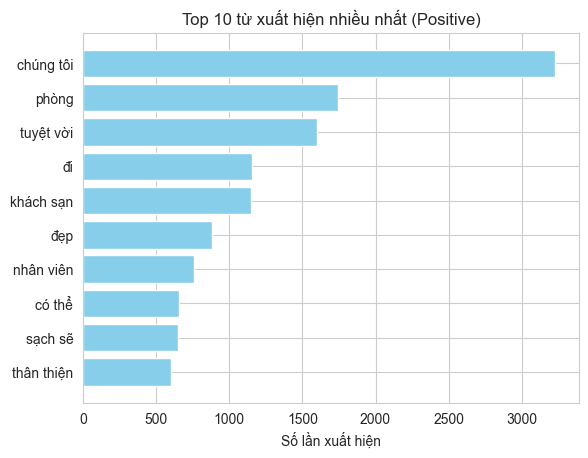

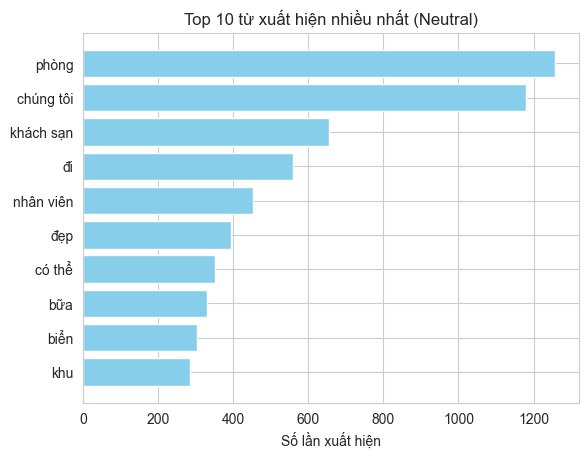

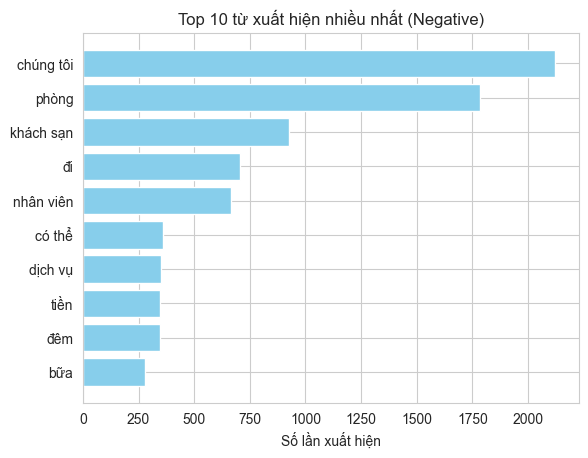

In [20]:
# Lấy top 10 từ cho mỗi sentiment
positive_top_words = get_top_words(visual_data, "positive")
neutral_top_words = get_top_words(visual_data, "neutral")
negative_top_words = get_top_words(visual_data, "negative")

# Vẽ biểu đồ cho sentiment
plot_top_words(positive_top_words, "Top 10 từ xuất hiện nhiều nhất (Positive)")
plot_top_words(neutral_top_words, "Top 10 từ xuất hiện nhiều nhất (Neutral)")
plot_top_words(negative_top_words, "Top 10 từ xuất hiện nhiều nhất (Negative)")

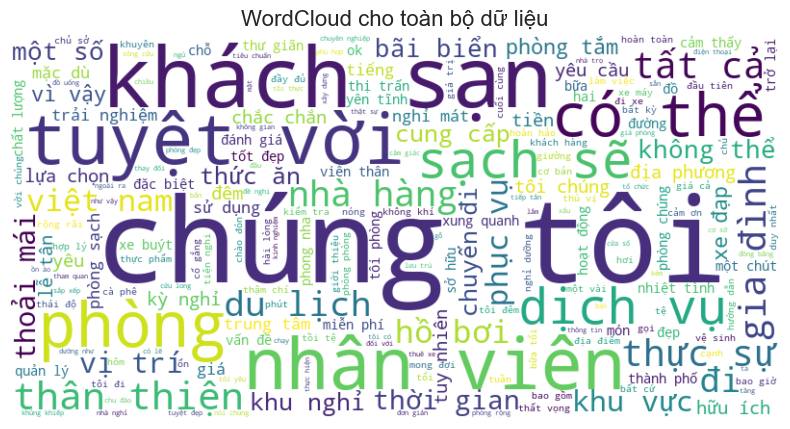

In [21]:
### Vẽ WordCloud
# Lấy toàn bộ dữ liệu trong cột review, thay dấu _ bằng khoảng trắng
text = " ".join(visual_data["review"]).replace("_", " ")

# Tạo WordCloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis',
    max_words=200
).generate(text)

# Vẽ WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")  # Ẩn trục
plt.title("WordCloud cho toàn bộ dữ liệu", fontsize=16)
plt.show()

# MODEL

Chuẩn bị dữ liệu

In [22]:
model_data = eda_data.copy()

In [23]:
# Chuẩn bị dữ liệu huấn luyện
X = model_data['review']
y = model_data['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
# Vector hóa dữ liệu
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [25]:
# Chuyển đổi TF-IDF từ sparse matrix sang dense array
X_train_tfidf_dense = X_train_tfidf.toarray()
X_test_tfidf_dense = X_test_tfidf.toarray()

# Mã hóa nhãn bằng LabelEncoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

Tạo các hàm cần thiết

In [26]:
def plot_confusion_matrix(y_true, y_pred, labels=None, label_encoder=None, title='Confusion Matrix (%)'):
    """
    Vẽ ma trận nhầm lẫn dưới dạng heatmap với tỷ lệ phần trăm.

    Args:
        y_true (array-like): Nhãn thực tế của dữ liệu kiểm tra.
        y_pred (array-like): Nhãn dự đoán của mô hình.
        labels (list, optional): Danh sách các lớp nhãn để hiển thị trên trục x và trục y của ma trận nhầm lẫn.
        label_encoder (LabelEncoder, optional): Một đối tượng LabelEncoder để chuyển đổi các nhãn từ dạng mã hóa trở lại dạng nguyên bản.
        title (str, optional): Tiêu đề của biểu đồ heatmap. Mặc định là 'Confusion Matrix (%)'.
    
    Returns:
        None: Hàm này chỉ vẽ ma trận nhầm lẫn và hiển thị biểu đồ, không trả về giá trị.
    """
    if label_encoder is not None:
        y_true = label_encoder.inverse_transform(y_true)
        y_pred = label_encoder.inverse_transform(y_pred)
    
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_percentage = cm / cm.sum(axis=1, keepdims=True) * 100
    
    sns.heatmap(cm_percentage, annot=True, fmt='.2f', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [27]:
def train_and_evaluate_model(model, param_grid, X_train, y_train, X_test, y_test):
    """
    Huấn luyện và đánh giá mô hình học máy sử dụng GridSearchCV để tìm kiếm tham số tối ưu.

    Args:
        model (sklearn estimator): Mô hình học máy chưa được huấn luyện (ví dụ: Logistic Regression, SVM, Naive Bayes).
        param_grid (dict): Từ điển các tham số và giá trị để tìm kiếm tham số tối ưu.
        X_train (array-like): Dữ liệu huấn luyện đầu vào.
        y_train (array-like): Nhãn dữ liệu huấn luyện.
        X_test (array-like): Dữ liệu kiểm tra đầu vào.
        y_test (array-like): Nhãn dữ liệu kiểm tra.

    Returns:
        best_model (sklearn estimator): Mô hình học máy với các tham số tối ưu đã được huấn luyện.
    """
    grid = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train, y_train)
    
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)
    
    print(f"Best Parameters: {grid.best_params_}")
    print(classification_report(y_test, y_pred))
    
    plot_confusion_matrix(y_test, y_pred, labels=grid.classes_)
    
    return best_model

3 mô hình học máy

Logistic Regression:
Best Parameters: {'C': 10, 'max_iter': 100, 'solver': 'lbfgs'}
              precision    recall  f1-score   support

    negative       0.82      0.79      0.80       165
     neutral       0.65      0.55      0.60       128
    positive       0.87      0.94      0.90       308

    accuracy                           0.82       601
   macro avg       0.78      0.76      0.77       601
weighted avg       0.81      0.82      0.81       601



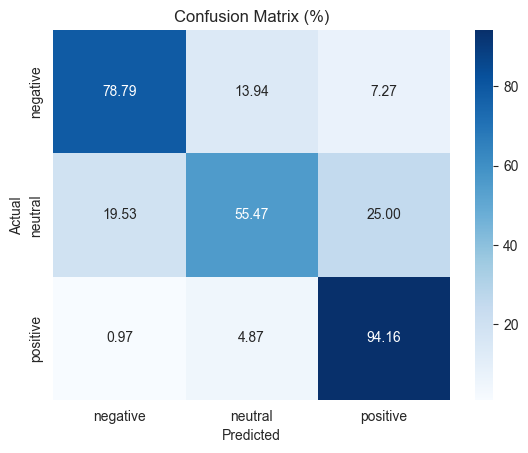

In [28]:
# Logistic Regression
print("Logistic Regression:")
logistic_params = {'C': [0.1, 1, 10], 'solver': ['lbfgs', 'liblinear'], 'max_iter': [100, 200]}
best_logistic = train_and_evaluate_model(LogisticRegression(), logistic_params, X_train_tfidf, y_train, X_test_tfidf, y_test)

Multinomial Naive Bayes:
Best Parameters: {'alpha': 0.1, 'fit_prior': False}
              precision    recall  f1-score   support

    negative       0.81      0.80      0.81       165
     neutral       0.70      0.35      0.47       128
    positive       0.80      0.97      0.88       308

    accuracy                           0.79       601
   macro avg       0.77      0.71      0.72       601
weighted avg       0.78      0.79      0.77       601



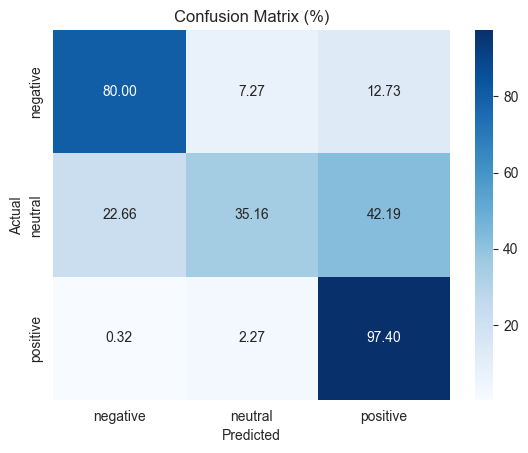

In [29]:
# Multinomial Naive Bayes
print("Multinomial Naive Bayes:")
nb_params = {'alpha': [0.1, 0.5, 1.0], 'fit_prior': [True, False]}
best_nb = train_and_evaluate_model(MultinomialNB(), nb_params, X_train_tfidf, y_train, X_test_tfidf, y_test)

Support Vector Machine:
Best Parameters: {'C': 1, 'kernel': 'linear'}
              precision    recall  f1-score   support

    negative       0.84      0.80      0.82       165
     neutral       0.63      0.61      0.62       128
    positive       0.89      0.92      0.90       308

    accuracy                           0.82       601
   macro avg       0.79      0.78      0.78       601
weighted avg       0.82      0.82      0.82       601



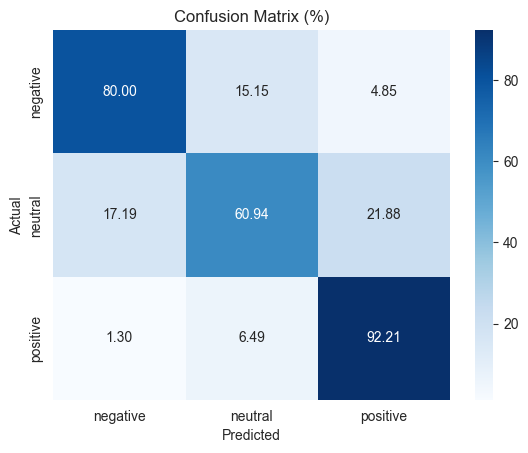

In [30]:
# SVM
print("Support Vector Machine:")
svm_params = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
best_svm = train_and_evaluate_model(SVC(), svm_params, X_train_tfidf, y_train, X_test_tfidf, y_test)

Mô hình học sâu

In [31]:
# Tạo mô hình FNN (Feedforward Neural Network)
model_fnn = Sequential([
    Input(shape=(X_train_tfidf_dense.shape[1],)), 
    Dense(128, activation='relu'),
    Dense(32, activation='relu'),
    Dense(len(label_encoder.classes_), activation='softmax')
])

# Biên dịch mô hình
model_fnn.compile(optimizer='adam', 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])

# Huấn luyện mô hình
history = model_fnn.fit(
    X_train_tfidf_dense,
    y_train_encoded,
    validation_data=(X_test_tfidf_dense, y_test_encoded),
    epochs=20,
    batch_size=32
)

# Dự đoán trên dữ liệu kiểm tra
y_pred = model_fnn.predict(X_test_tfidf_dense)
y_pred_labels = np.argmax(y_pred, axis=1)

Epoch 1/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 8s 87ms/step - accuracy: 0.5216 - loss: 0.9923 - val_accuracy: 0.7837 - val_loss: 0.6275
Epoch 2/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - accuracy: 0.9511 - loss: 0.4090 - val_accuracy: 0.8220 - val_loss: 0.4560
Epoch 3/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.9989 - loss: 0.0445 - val_accuracy: 0.8120 - val_loss: 0.4605
Epoch 4/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 1.0000 - loss: 0.0050 - val_accuracy: 0.8253 - val_loss: 0.4742
Epoch 5/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 0.8319 - val_loss: 0.4898
Epoch 6/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - accuracy: 1.0000 - loss: 8.9399e-04 - val_accuracy: 0.8303 - val_loss: 0.5038
Epoch 7/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - accuracy: 1.0000 - loss: 5.5321e-04 - val_accuracy: 0.8303 - val_loss: 0.5157
Epoch 8/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - accuracy: 1.0000 - loss: 4.0375e-04 - val_accuracy

Feedforward Neural Network:
              precision    recall  f1-score   support

    negative       0.84      0.84      0.84       165
     neutral       0.66      0.59      0.63       128
    positive       0.89      0.93      0.91       308

    accuracy                           0.83       601
   macro avg       0.80      0.79      0.79       601
weighted avg       0.83      0.83      0.83       601



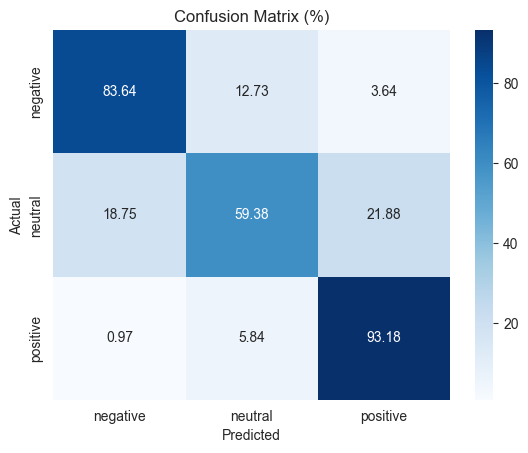

In [32]:
# In thông tin precision, recall, f1-score
print("Feedforward Neural Network:")
print(classification_report(y_test_encoded, y_pred_labels, target_names=label_encoder.classes_))

# Vẽ ma trận nhầm lẫn
plot_confusion_matrix(y_test_encoded, y_pred_labels, labels=label_encoder.classes_, label_encoder=label_encoder)

Kiểm tra lại mô hình bằng một câu test

In [33]:
def print_predictions(test_sentences, predictions, model_classes, model_name):
    """
    Hàm in kết quả dự đoán từ một mô hình.

    Args:
        test_sentences (list): Danh sách các câu cần dự đoán.
        predictions (list or numpy array): Nhãn dự đoán.
        model_classes (list or array): Danh sách các lớp nhãn (classes).
        model_name (str): Tên mô hình.
    """
    print(f"\nDự đoán với {model_name}:")
    
    # Nếu dự đoán là mảng một chiều (Logistic Regression, Naive Bayes, SVM)
    if predictions.ndim == 1:
        predicted_labels = predictions
    else:
        # Nếu dự đoán là mảng xác suất (FNN)
        predicted_labels = np.argmax(predictions, axis=1)
    
    # Nếu các dự đoán là nhãn (chuỗi), ta cần chuyển thành chỉ số
    if isinstance(predicted_labels[0], str):
        predicted_labels = [np.where(model_classes == label)[0][0] for label in predicted_labels]

    for sentence, label in zip(test_sentences, predicted_labels):
        print(f'Câu: "{sentence}" --> Dự đoán: {model_classes[label]}')


In [37]:
# Câu cần kiểm tra
test_sentences = ["Dịch vụ tốt.",
                  "Phòng ốc khá xấu."]

# Vector hóa câu test
X_test_sample_tfidf = vectorizer.transform(test_sentences)
X_test_sample_tfidf_array = X_test_sample_tfidf.toarray()

In [38]:
# Dự đoán với Logistic Regression
logistic_predictions = best_logistic.predict(X_test_sample_tfidf)
print_predictions(test_sentences, logistic_predictions, best_logistic.classes_, "Logistic Regression")

# Dự đoán với Multinomial Naive Bayes
nb_predictions = best_nb.predict(X_test_sample_tfidf)
print_predictions(test_sentences, nb_predictions, best_nb.classes_, "Multinomial Naive Bayes")

# Dự đoán với SVM
svm_predictions = best_svm.predict(X_test_sample_tfidf)
print_predictions(test_sentences, svm_predictions, best_svm.classes_, "SVM")

# Dự đoán với FNN
predictions = model_fnn.predict(X_test_sample_tfidf_array)
predicted_labels = np.argmax(predictions, axis=1)
model_classes = label_encoder.classes_
print_predictions(test_sentences, predicted_labels, model_classes, "FNN")



Dự đoán với Logistic Regression:
Câu: "Dịch vụ tốt." --> Dự đoán: negative
Câu: "Phòng ốc khá xấu." --> Dự đoán: negative

Dự đoán với Multinomial Naive Bayes:
Câu: "Dịch vụ tốt." --> Dự đoán: negative
Câu: "Phòng ốc khá xấu." --> Dự đoán: negative

Dự đoán với SVM:
Câu: "Dịch vụ tốt." --> Dự đoán: negative
Câu: "Phòng ốc khá xấu." --> Dự đoán: negative
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step

Dự đoán với FNN:
Câu: "Dịch vụ tốt." --> Dự đoán: negative
Câu: "Phòng ốc khá xấu." --> Dự đoán: negative
